In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange

from ensae_3a_gadmm.admm import admm_objective_function
from ensae_3a_gadmm.gadmm import display_df_log
from ensae_3a_gadmm.logistic_regression import f

t = time.time()

## Importation of data

Data is downloaded from the following repo : https://github.com/chentianyi1991/LAG-code 

In [2]:
data = np.loadtxt("data/data2/data.txt")
data.shape

(351, 34)

In [3]:
y = np.loadtxt("data/data2/y.txt", dtype=int)
y.shape

(351,)

In [4]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(scaled_data)
pca_data.shape

(351, 2)

In [5]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,-1.668242,-2.054597,0
1,0.823940,-2.583636,1
2,-2.034095,-0.748245,0
3,1.252374,1.363326,1
4,0.017756,-1.845357,0
...,...,...,...
346,-3.156856,-0.000433,0
347,-3.562330,0.324750,0
348,-3.512043,0.204754,0
349,-3.308935,-0.343454,0


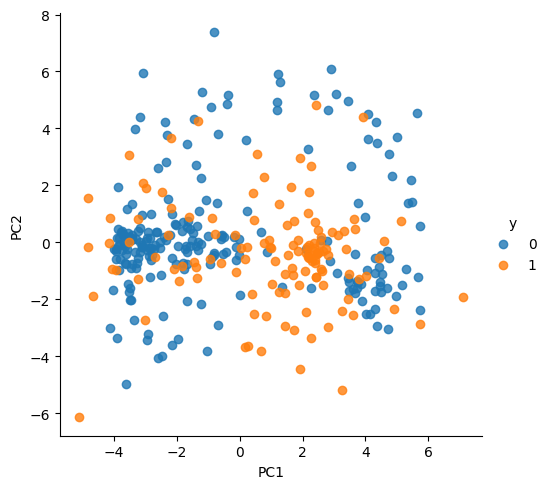

In [6]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [7]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = scaled_data
data = temp_data
data.shape

(351, 35)

In [8]:
d = data.shape[1]
d

35

## Logistic Regression

We compute LR with scikit-learn to compare our results

In [9]:
rho = 1

In [10]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.9259259259259259

In [11]:
opt_theta = clf.coef_
opt_theta

array([[-0.16162871, -2.25989579,  0.        , -0.8004997 ,  0.00761144,
        -0.99946311, -0.9730252 , -0.54479263, -1.07079607, -0.66992926,
        -0.19357204,  0.61352733,  0.18207117,  0.0964342 , -0.3013256 ,
        -0.67571157,  0.42383201, -0.09854566, -0.56972128,  0.80706223,
        -0.01100896, -0.09950051,  1.3649529 , -0.80355806, -0.40487275,
        -0.68251785, -0.18623943,  1.39654551,  0.07158301, -0.53248591,
        -0.93991849, -0.53082438,  0.17228759,  0.37834172,  0.86564326]])

In [12]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.18694318521111666

## ADMM not parallelized

In [13]:
K = 1000  # number of iterations
M = 4  # number of workers
rho = 1

In [14]:
split_data = np.array_split(data, M)

In [15]:
split_data[0].shape

(88, 35)

In [16]:
split_y = np.array_split(y, M)

In [17]:
f(opt_theta, data, y)

0.18694318521111672

In [18]:
# Initialisation
Theta = np.zeros((M, d))
global_theta = np.zeros(d)
Lamb = np.zeros((M, d))

df_log_admm = []

t1 = time.time()
for k in trange(K):
    # Step 1 : find argmin of objective function
    for n in range(M):
        sample_data = split_data[n]
        sample_y = split_y[n]
        lamb = Lamb[n]
        res = minimize(
            admm_objective_function,
            x0=Theta[n],
            args=(sample_data, sample_y, lamb, global_theta, rho),
        )
        assert res.success is True
        Theta[n] = res.x

    # Step 2 : update global_theta
    Sum_Theta = np.sum(Theta, axis=0)
    Sum_Lamb = np.sum(Lamb, axis=0)
    global_theta = (1 / M) * (Sum_Theta + (1 / rho) * Sum_Lamb)

    # Step 3 : update locally lambda
    for n in range(M):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - global_theta)

    for n in range(M):
        df_log_admm.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log_admm)

print(f"Temps : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Temps : 00:03:03


In [19]:
Theta[0]

array([ 6.96592151e-01, -4.59955917e+00, -7.45348599e-06, -9.18239637e-01,
        3.05211664e-01, -1.65967487e+00, -1.51087523e+00, -5.18460576e-01,
       -1.67817193e+00, -1.24939670e+00, -2.20383999e-01,  1.61665573e+00,
        4.67308796e-01,  1.75138765e-01, -2.33378957e-01, -1.55776386e+00,
        1.22032211e+00, -2.71562129e-01, -1.01574686e+00,  2.15766922e+00,
       -4.66698582e-02, -9.63497499e-02,  1.68577343e+00, -1.47831204e+00,
       -7.54381843e-01, -1.10964851e+00,  1.31111672e-02,  2.40851555e+00,
        4.41832806e-02, -1.04975219e+00, -1.81639183e+00, -7.77834609e-01,
        7.31188288e-02,  3.16899117e-01,  1.38878908e+00])

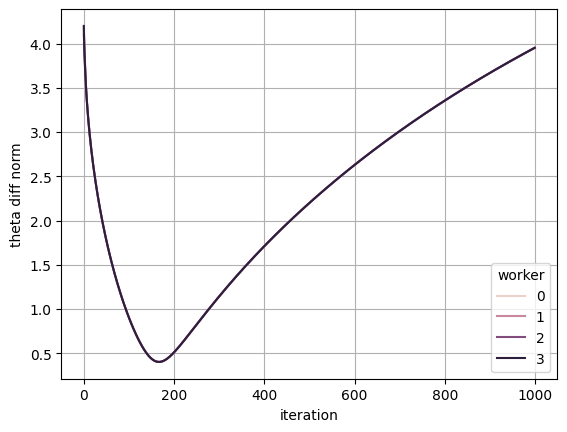

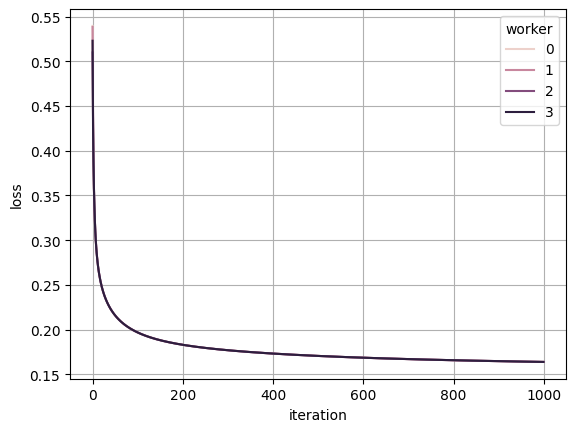

,worker,theta diff norm,loss
0,0,3.952325,0.163866
1,1,3.952325,0.163866
2,2,3.952326,0.163866
3,3,3.952327,0.163866


In [20]:
display_df_log(df_log, data, y, M, Theta, opt_theta)

In [21]:
print(
    f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}"
)

Temps d'exécution total : 00:03:05
